In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from scipy import spatial
import netCDF4 as nc
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import read_data, concatenation, radar

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_palette('husl')

### Read data

In [3]:
date = '20140811'
radar_panel = \
read_data.radar_to_panel( '../data/data_20140811.nc',
               var_name='radar', time_unit='ns', dim_map = {'lat' : 'latitude', 'lon' :
                                             'longitude', 'time' : 'time'})
veh = read_data.read_vehicle_data('../data/20140811.csv')
labels = pd.read_csv('../data/hi_res_labeling_2014-08-11_raw.csv')
wu_df, wu_locs = read_data.read_wu_gages('../data/rain_gages')

# Correct gage data
wu_df.drop('KMIYPSIL10', axis=1, inplace=True)
wu_day = wu_df.loc[date]
gages = wu_df.columns[wu_df.loc[date].any()]

### Join vehicles to nearest gages

In [4]:
vehgages = {}

for gage in gages:
    df = concatenation.join_gage_to_vehicle(wu_df[gage].dropna(),
                                      wu_locs.loc[gage, ['lon', 'lat']],
                                      veh)
    vehgages[gage] = df

gage_dists = pd.concat([vehgages[gage]['Dist_km'].rename(gage) for gage in vehgages], axis=1)
gage_readings = pd.concat([vehgages[gage][gage] for gage in vehgages], axis=1)
mindist = gage_dists.min(axis=1)
idxmindist = gage_dists.idxmin(axis=1)
idxmindist_int = idxmindist.map(pd.Series(np.arange(gage_readings.shape[1]), index=gage_readings.columns))
closest_readings = gage_readings.values[np.arange(len(gage_readings)), idxmindist_int]
veh['gage'] = closest_readings

### Convert relative to absolute time for labels

In [5]:
veh['id'] = veh['Device'].astype(str) + '-' + veh['Trip'].astype(str)
veh = veh.reset_index()
trip_starts = veh.groupby('id').min()['Time']
labels['dt'] = labels['time (in centiseconds)'] / 100
labels['id'] = labels['device id'].astype(str) + '-' + labels['trip id'].astype(str)
labels['trip start'] = labels['id'].map(trip_starts)
labels['time'] = labels['trip start'] + pd.to_timedelta(labels['dt'], unit='s')

### Combine original vehicle dataset with labels

In [6]:
combined_data = pd.DataFrame()

for vtid in veh['id'].unique():
    veh_subset = veh[veh['id'] == vtid]
    labels_subset = labels[labels['id'] == vtid]
    labels_ix = labels_subset.index.values
    axis_time = veh_subset['Time'].values
    input_time = labels_subset['time'].values
    dist, ix = concatenation.time_join(axis_time, input_time)
    labels_subset['time_dist'] = dist
    labels_subset['ref_time'] = axis_time[ix]
    veh_data = veh_subset[['Latitude', 'Longitude', 'Wiper', 'GPS_Speed', 'gage']].iloc[ix].set_index(labels_subset.index)
    combined_subset = pd.concat([labels_subset, veh_data], axis=1)
    combined_data = combined_data.append(combined_subset)
    
combined_data = combined_data[['time', 'device id', 'trip id',
                               'Latitude', 'Longitude', 'GPS_Speed',
                               'wiper', 'camera_rain', 'gage']]

### Filter vehicle data

In [7]:
ymin = radar_panel.major_axis.min()
ymax = radar_panel.major_axis.max()
xmin = radar_panel.minor_axis.min()
xmax = radar_panel.minor_axis.max()

filt_comb = combined_data[(combined_data['Latitude'] > ymin) & (combined_data['Latitude'] < ymax) &
        (combined_data['Longitude'] > xmin) & (combined_data['Longitude'] < xmax)]
filt_comb = filt_comb[filt_comb['GPS_Speed'] > 1]
invalid = [10150, 10151, 10589, 10139, 10615]
filt_comb = filt_comb[~filt_comb['device id'].isin(invalid)]
filt_comb = filt_comb.dropna()

### Get corresponding radar data

In [8]:
z0, v_tdist, v_xydist = concatenation.panel_spacetime_index(radar_panel, filt_comb['time'].values,
                                              filt_comb[['Longitude', 'Latitude']].values, return_distance=True)
r = radar_panel.values[z0[0], z0[1], z0[2]]
filt_comb['radar'] = r
filt_comb['radar'] = filt_comb['radar'].fillna(0)

In [9]:
perf = {'Wiper' : {}, 'Radar' : {}, 'Gage' : {}}

alpha = 0.0
perf['Wiper']['TPR'] = ((filt_comb['wiper'] > alpha) & (filt_comb['camera_rain'] != 0)).sum() / (filt_comb['wiper'] > alpha).sum()
perf['Wiper']['TNR'] = ((filt_comb['wiper'] <= alpha) & (filt_comb['camera_rain'] == 0)).sum() / (filt_comb['wiper'] <= alpha).sum()
perf['Radar']['TPR'] = ((filt_comb['radar'] > 0.0) & (filt_comb['camera_rain'] != 0)).sum() / (filt_comb['radar'] > 0.0).sum()
perf['Radar']['TNR'] = ((filt_comb['radar'] == 0.0) & (filt_comb['camera_rain'] == 0)).sum() / (filt_comb['radar'] == 0.0).sum()
perf['Gage']['TPR'] = ((filt_comb['gage'] > 0.0) & (filt_comb['camera_rain'] != 0)).sum() / (filt_comb['gage'] > 0.0).sum()
perf['Gage']['TNR'] = ((filt_comb['gage'] == 0.0) & (filt_comb['camera_rain'] == 0)).sum() / (filt_comb['gage'] == 0.0).sum()
pd.DataFrame.from_dict(perf).sort_index(ascending=False)

,Gage,Radar,Wiper
TPR,0.951835,0.890219,0.956704
TNR,0.659293,0.905526,0.966524


In [10]:
# Percent difference in TPR between wiper and radar
print('TPR Difference between wiper and radar: ', 100*((((filt_comb['wiper'] > 0.0) & (filt_comb['camera_rain'] != 0)).sum() / (filt_comb['wiper'] > 0.0).sum()) - \
(((filt_comb['radar'] > 0.0) & (filt_comb['camera_rain'] != 0)).sum() / (filt_comb['radar'] > 0.0).sum())))
print('TNR Difference between wiper and radar: ', 100*((((filt_comb['wiper'] == 0.0) & (filt_comb['camera_rain'] == 0)).sum() / (filt_comb['wiper'] == 0.0).sum()) - \
(((filt_comb['radar'] == 0.0) & (filt_comb['camera_rain'] == 0)).sum() / (filt_comb['radar'] == 0.0).sum())))

TPR Difference between wiper and radar:  6.6484435925530665
TNR Difference between wiper and radar:  6.099805855072004


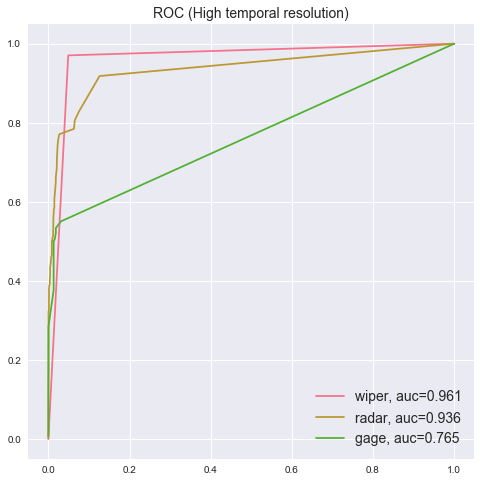

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

xw, yw, _ = roc_curve(filt_comb['camera_rain'].values, filt_comb['wiper'].values, 1)
xr, yr, _ = roc_curve(filt_comb['camera_rain'].values, filt_comb['radar'].values, 1)
xg, yg, _ = roc_curve(filt_comb['camera_rain'].values, filt_comb['gage'].values, 1)

w_auc = auc(xw, yw)
r_auc = auc(xr, yr)
g_auc = auc(xg, yg)

plt.plot(xw, yw, label='wiper, auc={0:.3f}'.format(w_auc))
plt.plot(xr, yr, label='radar, auc={0:.3f}'.format(r_auc))
plt.plot(xg, yg, label='gage, auc={0:.3f}'.format(g_auc))

plt.title('ROC (High temporal resolution)', fontsize=14)
plt.legend(fontsize=14)